# Импорт библиотек

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from model import UNET_VGG,FCN,FCN2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, model_from_json, load_model
import matplotlib.pyplot as plt
import numpy as np
import buzzard as buzz
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import tqdm
from shapely import speedups
import pickle
import descartes
import tifffile as tiff
from PIL import Image



# Описание дополнительных функций

In [3]:
def train(model_nn, dataset,
          epochs=10, batch_size=1000,
          learning_rate=1e-4, beta_1 = 0.9, beta_2= 0.999, initialize_weights_vgg = False, load_weights=False):
    X_train,Y_train,X_test,Y_test = dataset
    
    
    
    adam_optimizer = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)
    model_nn.model.compile(loss= 'binary_crossentropy',
                           optimizer=adam_optimizer)
    if load_weights:
        model_nn.model.load_weights("weights.best.hdf5")
    
    if initialize_weights_vgg:
        model_vgg = VGG16(weights='imagenet',input_shape=(224, 224, 3))
        for i in range(18): 
            model_nn.model.layers[i].set_weights(model_vgg.layers[i].get_weights())
        
      
    # checkpoint
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    history = model_nn.model.fit(X_train, Y_train,
                                 epochs=epochs, batch_size=batch_size,
                                 validation_data=(X_test,Y_test),
                                 callbacks=callbacks_list) 
    
    model_nn.save_model()
    return model_nn, history

In [ ]:
#Описание моделей
class Model_NN(object):
    def __init__(self):
        self.name = None
        self.model = None
        self.input_size = None

    
    def model(self):
        return self.model
    
    
    def save_model(self):
        # DEPRECATED
        print("Saving model...")
        filepath='models/'+self.name+'_'+str(self.input_size)+'.h5'
        self.model.save(filepath)
        
    def load_model(self):
        filepath='models/'+self.name+'_'+str(self.input_size)+'.h5'
        self.model = load_model(filepath)
        print("Model loaded")
        return self
        
    
    def save_model_old(self):
        # DEPRECATED
        print("Saving model...")
        name_weights='models/'+self.name+'_'+str(self.input_size)+'.h5'
        name_model='models/'+self.name+'_'+str(self.input_size)+'.json'        
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
    
    def load_model_old(self):
        # DEPRECATED
        name_weights='models/'+self.name+'_'+str(self.input_size)+'.h5'
        name_model='models/'+self.name+'_'+str(self.input_size)+'.json'
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("adam", "binary_crossentropy")
        self.model = model
        return self
    
class UNET_VGG(Model_NN):
    def __init__(self,input_size):
        super(UNET_VGG,self).__init__()
        if input_size != 224:
            print("Error : incorrect input image size")
            # TODO : adapt  weights load for other input size
        else:
            self.name = "unet_vgg16"
            self.model = self.unet_vgg16()
            self.input_size = input_size
    
    
    def unet_vgg16(self):
        """
        U-Net architecture based on the pre-trained network VGG16.
        The encoding part is the same that the VGG16. The weights of the 18 first
        layers (encoder part) must be initialized after compilation of the model.
        (see test_setting_weight function)
        
        Return
        ------
        model : keras model
            Keras model for the U-Net structure
        """
        
        # =============================================================================
        # Encoder part
        # =============================================================================
        i   = Input((224,224,3))
        c1  = Conv2D(64,(3,3),activation='relu',padding='same')(i)
        c2  = Conv2D(64,(3,3),activation='relu',padding='same')(c1)
        mp1 = MaxPooling2D((2,2))(c2)
        c3  = Conv2D(128,(3,3),activation='relu',padding='same')(mp1)
        c4  = Conv2D(128,(3,3),activation='relu',padding='same')(c3)
        mp2 = MaxPooling2D((2,2))(c4)
        c5  = Conv2D(256,(3,3),activation='relu',padding='same')(mp2)
        c6  = Conv2D(256,(3,3),activation='relu',padding='same')(c5)
        c7  = Conv2D(256,(3,3),activation='relu',padding='same')(c6)
        mp3 = MaxPooling2D((2,2))(c7)
        c8  = Conv2D(512,(3,3),activation='relu',padding='same')(mp3)
        c9  = Conv2D(512,(3,3),activation='relu',padding='same')(c8)
        c10 = Conv2D(512,(3,3),activation='relu',padding='same')(c9)
        mp4 = MaxPooling2D((2,2))(c10)
        c11  = Conv2D(512,(3,3),activation='relu',padding='same')(mp4)
        c12  = Conv2D(512,(3,3),activation='relu',padding='same')(c11)
        c13 = Conv2D(512,(3,3),activation='relu',padding='same')(c12)
        mp5 = MaxPooling2D((2,2))(c13)
        # =============================================================================
        # Center part
        # =============================================================================
        c14 = Conv2D(512,(3,3),activation='relu',padding='same')(mp5)
        # =============================================================================
        # Decoder part
        # =============================================================================
        d1 = Conv2DTranspose(512,(3,3),activation='relu',padding='same',strides=2)(c14)  # or 256?
        m1 = concatenate([d1,c13])
        c15 = Conv2D(512,(3,3),activation='relu',padding='same')(m1)
        d2 = Conv2DTranspose(256,(3,3),activation='relu',padding='same',strides=2)(c15)
        m2 = concatenate([d2,c10])
        c16 = Conv2D(512,(3,3),activation='relu',padding='same')(m2)
        d3 = Conv2DTranspose(128,(3,3),activation='relu',padding='same',strides=2)(c16)
        m3 = concatenate([d3,c7])
        c17 = Conv2D(256,(3,3),activation='relu',padding='same')(m3)
        d4 = Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=2)(c17)
        m4 = concatenate([d4,c4])
        c18 = Conv2D(128,(3,3),activation='relu',padding='same')(m4)
        d5 = Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=2)(c18)
        m5 = concatenate([d5,c2])
        c19 = Conv2D(1,(3,3),activation='sigmoid',padding='same')(m5)
        
        model = Model(inputs=i,outputs=c19)
        return model


class FCN(Model_NN):
    def __init__(self,input_size):
        super(FCN,self).__init__()
        self.name = "fcn"
        self.input_size = input_size
        self.model = self.fcn()
    
    def fcn(self):
        # =============================================================================
        # Encoder part
        # =============================================================================
        i   = Input((self.input_size,self.input_size,3))
        c1 = Conv2D(16,(3,3),activation='relu',padding='same')(i)
        c2 = Conv2D(32,(3,3),activation='relu',padding='same')(c1)
        mp1 = MaxPooling2D((2,2))(c2)
        c3 = Conv2D(64,(3,3),activation='relu',padding='same')(mp1)
        d1 = Conv2DTranspose(16,(3,3),activation='relu',padding='same',strides=2)(c3)
        c4 = Conv2D(1,(3,3),activation='sigmoid',padding='same')(d1)
        
        model = Model(inputs=i,outputs=c4)
        return model


class FCN2(Model_NN):
    def __init__(self,input_size):
        super(FCN2,self).__init__()
        self.name = "fcn2"
        self.input_size = input_size
        self.model = self.fcn2()
    
    def fcn2(self):
        # =============================================================================
        # Encoder part
        # =============================================================================
        i   = Input((self.input_size,self.input_size,3))
        c1  = Conv2D(64,(3,3),activation='relu',padding='same')(i)
        c2  = Conv2D(64,(3,3),activation='relu',padding='same')(c1)
        mp1 = MaxPooling2D((2,2))(c2)
        c3  = Conv2D(128,(3,3),activation='relu',padding='same')(mp1)
        mp2 = MaxPooling2D((2,2))(c3)
        # =============================================================================
        # Center part
        # =============================================================================
        c4 = Conv2D(128,(3,3),activation='relu',padding='same')(mp2)
        # =============================================================================
        # Decoder part
        # =============================================================================
        d1 = Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=2)(c4) 
        m1 = concatenate([d1,c3])
        d2 = Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=2)(m1)
        m2 = concatenate([d2,c2])
        c5 = Conv2D(64,(3,3),activation='relu',padding='same')(m2)
        c6 = Conv2D(1,(3,3),activation='sigmoid',padding='same')(c5)
        
        model = Model(inputs=i,outputs=c6)
        
        return model
    


def test_setting_weight():
    model = UNET_VGG()
    
    model_vgg = VGG16(weights='imagenet',input_shape=(224, 224, 3))
    model_vgg.summary()
    
    # We must init weight after the compilation
    model.model.compile(loss= 'categorical_crossentropy',
                        optimizer='adam',metrics=['accuracy'])
    
    # Initializing weight with trained vgg16, 18 = size of the encoder part
    for i in range(18): 
        model.model.layers[i].set_weights(model_vgg.layers[i].get_weights())
    
    # Check model structure
    model.model.summary()

In [4]:
#Функции постобработки
def tile_image(tile_size, ds, fp):
    '''
    Tiles image in several tiles of size (tile_size, tile_size)
    Params
    ------
    tile_siz : int
        size of a tile in pixel (tiles are square)
    ds: Datasource
        Datasource of the input image (binary)
    fp : footprint
        global footprint 
    Returns
    -------
    rgb_array : np.ndarray
        array of dimension 5 (x number of tiles, y number of tiles,
        x size of tile, y size of tile, number of canal)
    tiles : np.ndarray of footprint
        array of of size (x number of tiles, y number of tiles) 
        that contains footprint information
    
        
    '''
    tiles = fp.tile((tile_size,tile_size))
    rgb_array = np.zeros([tiles.shape[0],tiles.shape[0],tile_size,tile_size,3],
                         dtype='uint8')
    for i in range(tiles.shape[0]):
        for j in range(tiles.shape[1]):
            rgb_array[i,j] = ds.rgb.get_data(band=(1,2,3), fp=tiles[i,j])
    return rgb_array, tiles

def untile(rgb_array,tiles,fp):
    '''
    DEPRECATED
    Get the tile binary array and the footprint matrix and returns the reconstructed image
    Params
    ------
    rgb_array : np.ndarray
        array of dimension 5 (x number of tiles, y number of tiles,
        x size of tile, y size of tile)
    tiles : np.ndarray of footprint
        array of of size (x number of tiles, y number of tiles) 
        that contains footprint information
    Returns
    -------
    rgb_reconstruct : np.ndarray
        reconstructed rgb image
    '''
    # initialization of the reconstructed rgb array
    rgb_reconstruct = np.zeros([
        rgb_array.shape[0]*rgb_array.shape[2], #pixels along x axis
        rgb_array.shape[1]*rgb_array.shape[3], # pixels along y axis
        ], dtype='uint8')
    
    for i in range(tiles.shape[0]):
        for j in range(tiles.shape[1]):
            tile_size = tiles[i,j].rsize
            rgb_reconstruct[i*tile_size[0]:(i+1)*tile_size[0],
                            j*tile_size[1]:(j+1)*tile_size[1]
                            ] = rgb_array[i,j]
    rgb_reconstruct = rgb_reconstruct[:fp.rsize[0],:fp.rsize[0]] # delete padding
    return rgb_reconstruct

def untile_and_predict(rgb_array,tiles,fp,model):
    '''
    Get the tile binary array and the footprint matrix and returns the reconstructed image
    Params
    ------
    rgb_array : np.ndarray
        array of dimension 5 (x number of tiles, y number of tiles,
        x size of tile, y size of tile,3)
    tiles : np.ndarray of footprint
        array of of size (x number of tiles, y number of tiles) 
        that contains footprint information
    Returns
    -------
    rgb_reconstruct : np.ndarray
        reconstructed rgb image
    '''
    # initialization of the reconstructed rgb array
    binary_reconstruct = np.zeros([
        rgb_array.shape[0]*rgb_array.shape[2], #pixels along x axis
        rgb_array.shape[1]*rgb_array.shape[3], # pixels along y axis
        ], dtype='uint8')
    
    for i in tqdm.tqdm(range(tiles.shape[0])):
        for j in range(tiles.shape[1]):
            tile_size = tiles[i,j].rsize
            # predict the binaryzed image
            predicted = predict_image(rgb_array[i,j],model_nn)
            # add the image in the global image
            binary_reconstruct[i*tile_size[0]:(i+1)*tile_size[0],
                            j*tile_size[1]:(j+1)*tile_size[1]
                            ] = predicted
    # delete the tilling padding
    binary_reconstruct = binary_reconstruct[:fp.rsize[0],:fp.rsize[0]] 
    return binary_reconstruct


def show_polygons(rgb,fp,poly_list):
    '''
    Display polygons from a polygon list in a array linked to the adapted footprint
    Parameters
    ----------
    rgb : np.ndarray
        image in rgb format (n,d,3)
    fp : footprint
        footprint linked to the array
    poly_list : list of shapely.geometry.polygons objects
        list of polygons to display
    '''
    # Show image with matplotlib and descartes
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('Roof boundary')
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[fp.lx, fp.rx, fp.by, fp.ty])
        
    for poly in poly_list:
        ax.add_patch(descartes.PolygonPatch(poly, fill=False, ec='#ff0000', lw=3, ls='--'))
    plt.show()

def predict_image(image,model):
    '''
    Predict one image with the model. Returns a binary array
    Parameters
    ----------
    image : np.ndarray
        rgb input array of the (n,d,3)
    model : Model object
        trained model for the prediction of image (tile_size * tile_size)
    '''
    shape_im = image.shape
    image = image/127.5-1.0 # normalise data
    predicted_image = model.model.predict(image.reshape(1,shape_im[0], shape_im[1],3))    
    predicted_image = predicted_image.reshape(shape_im[0],shape_im[1])     
    predicted_image = (predicted_image> 0.5)*255    
    return predicted_image


def test_tile_function(ds_rgb, tiles):
    '''
    Test tile function to see how it reacts with corners 
    '''
    # test size of tiles
    print("Size tile in meters : " +str(tiles[0,0].size))
    print("Size tile in pixels : " +str(tiles[0,0].rsize))
    size_tiles_meters = tiles[0,0].size[0]*len(tiles)
    size_tiles_pixels= tiles[0,0].rsize[0]*len(tiles)
    print("Size total "+str(len(tiles))+ " tiles : " + str(size_tiles_meters))
    print("Size total "+str(len(tiles))+ " tiles : " + str(size_tiles_pixels))
    tile = tiles[0]
    for fp_tile in tile:
        tl = fp_tile.tl
        expected_tile = tl[0]+fp_tile.size[0]
        print(tl[0])
        print("expected :" + str(expected_tile))
    
    #une tile : 224 pixels, 67.2 m
    #23 tiles : 5152 pixels, 1545.6 -> OK
    # les tiles doivent être coupées:
    cut_rgb = ds_rgb.rgb.get_data(band=(1, 2, 3), fp=tiles[22,22]).astype('uint8')    
    plt.imshow(cut_rgb)
    plt.show()


def predict_map(model,tile_size,ds_rgb,fp):
    '''
    Pipeline from the whole rasper and footprint adapted to binary array
    Params
    ------
    model : Model object
        trained model for the prediction of image (tile_size * tile_size)
    tile_size : int
        size of tiles (i.e. size of the input array for the model)
    ds_rgb : datasource
        Datasource object for the rgb image
    fp : footprint
        footprint of the adapted image (with downsampling factor)
    '''
    print("Tiling images...")
    rgb_array, tiles = tile_image(tile_size, ds_rgb, fp)
    print("Predicting tiles..")
    predicted_binary = untile_and_predict(rgb_array,tiles,fp,model)
    print("Image binaryzed")
    return predicted_binary

def predict_file(file, model_nn,
                 images_train= "AerialImageDataset/train/images/",
                 downsampling_factor=3,tile_size=128):
    '''
    Predict binaryzed array and adapted footprint from a file_name
    Parameters
    ----------
    file : string
        file name (with extension)
    model_nn : Model object
        trained model for the prediction of image (tile_size * tile_size)
    images_train : string
        folder name for whole input images
    downsampling_factor : int
        downsampling factor (to lower resolution)
    tile_size : int
        size of a tile (in pixel) i.e. size of the input images 
        for the neural network
    '''
    ds_rgb = buzz.DataSource(allow_interpolation=True)
    rgb_path = images_train + file
    ds_rgb.open_raster('rgb', rgb_path)
    

    fp= buzz.Footprint(
            tl=ds_rgb.rgb.fp.tl,
            size=ds_rgb.rgb.fp.size,
            rsize=ds_rgb.rgb.fp.rsize/downsampling_factor,
    ) #unsampling

    predicted_binary = predict_map(model_nn,tile_size,ds_rgb,fp)
    return predicted_binary, fp

def test_pipeline(file,model_nn,images_train,gt_train,downsampling_factor,tile_size):
    '''
    Test the whole pipeline from a file name to a binaryzed array and compare 
    it to the referenced binary image
    '''
    # predinction
    predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
    # Loading reference 
    binary_path = gt_train + file   
    ds_binary = buzz.DataSource(allow_interpolation=True)
    ds_binary.open_raster('rgb', binary_path) 
    binary = ds_binary.rgb.get_data(band=(1), fp=fp)
    
    # Plotting results
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('Predicted segmentation')
    ax = fig.add_subplot(111)
    ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    plt.show()
    
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('True segmentation')
    ax = fig.add_subplot(111)
    ax.imshow(binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    plt.show()
    
def test_save_polynoms(file):
    '''
    test polynom identification of saving for one file
    '''
    # Loading reference 
    binary_path = gt_train + file   
    ds_binary = buzz.DataSource(allow_interpolation=True)
    ds_binary.open_raster('rgb', binary_path) 
    fp= buzz.Footprint(
            tl=ds_binary.rgb.fp.tl,
            size=ds_binary.rgb.fp.size,
            rsize=ds_binary.rgb.fp.rsize/downsampling_factor,
    ) #unsampling
    binary = ds_binary.rgb.get_data(band=(1), fp=fp)
    save_polynoms(file,binary,fp)
    
    
def save_polynoms(file,binary,fp):
    '''
    Find polynoms in a binary array and save them at the geojson format
    Parameters
    ----------
    file : string
        file name (with extension)
    binary : np.ndarray
        array that contains the whole binaryzed image
    fp : footprint
        footprint linked to the binary array
    '''
    poly = fp.find_polygons(binary)
    
    path = 'geoJSON/'+file.split('.')[0]+'.geojson'
    ds = buzz.DataSource(allow_interpolation=True)
    ds.create_vector('dst', path, 'polygon', driver='GeoJSON')
    for p in poly:
        ds.dst.insert_data(p)
    ds.dst.close()    
    
def compute_files(model_nn,images_train,downsampling_factor,tile_size):
    '''
    Compute polynoms for each files in images_train folder and save them in
    geojson format.
    Parameters
    ----------
    model : Model object
        trained model for the prediction of image (tile_size * tile_size)
    images_traian : string
        folder name for whole input images
    downsampling_factor : int
        downsampling factor (to lower resolution)
    tile_size : int
        size of a tile (in pixel) i.e. size of the input images 
        for the neural network
    '''
    files = [f for f in listdir(images_train) if isfile(join(images_train, f))]
    for i in range(len(files)):
        print("Processing file number "+str(i)+"/"+str(len(files))+"...")
        predicted_binary, fp = predict_file(files[i],model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
        save_polynoms(files[i],predicted_binary,fp)

def display_results(file,gt_train = "AerialImageDataset/train/gt/",
                    images_train = "AerialImageDataset/train/images/",
                   polygons_path = "geoJSON/",downsampling_factor=1):
    geojson_file = polygons_path+file.split('.')[0]+'.geojson'
    ds = buzz.DataSource(allow_interpolation=True)
    ds.open_raster('rgb', images_train+file)
    ds.open_vector('roofs',geojson_file,driver='geoJSON')
    
    
    # Build a low resolution Footprint to perform quicker calculations 
    fp = buzz.Footprint(
        tl=ds.rgb.fp.tl,
        size=ds.rgb.fp.size,
        rsize=ds.rgb.fp.rsize // downsampling_factor,
    )
    
    rgb = ds.rgb.get_data(band=(1, 2, 3), fp=fp).astype('uint8')
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    plt.show()
    polygons = ds.roofs.iter_data(None) 
    rgb = ds.rgb.get_data(band=(1, 2, 3), fp=fp).astype('uint8')
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('Prediction')
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    for polygon_roof in polygons:
        ax.add_patch(descartes.PolygonPatch(polygon_roof, fill=False, ec='#ff0000', lw=3, ls='--'))
    plt.show()

In [6]:
#Оценка модели
def poly_to_binary(file,
                   gt_train = "AerialImageDataset/train/gt/",
                   polygons_path = "geoJSON/",downsampling_factor = 4):
    ds = buzz.DataSource(allow_interpolation=True)
    ds.open_raster('binary', gt_train+file) 
    geojson_file = polygons_path+file.split('.')[0]+'.geojson'
    ds.open_vector('polygons',geojson_file,driver='geoJSON')
    
    fp = buzz.Footprint(
            tl=ds.binary.fp.tl,
            size=ds.binary.fp.size,
            rsize=ds.binary.fp.rsize/downsampling_factor ,
        )
    
    binary = ds.binary.get_data(band=(1), fp=fp).astype('uint8')
    binary_predict = np.zeros_like(binary)
    
    for poly in ds.polygons.iter_data(None):
        mark_poly = fp.burn_polygons(poly)
        binary_predict[mark_poly] = 1
    return binary,binary_predict

def iou(binary,binary_pred):
    b = binary.astype('bool')
    bp = binary_pred.astype('bool')
    inter = np.logical_and(b,bp)
    union = np.logical_or(b,bp)
    return np.sum(inter)/np.sum(union)

def dice(binary,binary_pred):
    b = binary.astype('bool')
    bp = binary_pred.astype('bool')
    inter = np.logical_and(b,bp)
    union = np.logical_or(b,bp)
    return (np.sum(inter)+np.sum(inter))/(np.sum(union)+np.sum(inter))

def compute_iou(images_train,downsampling_factor=4):
    files = [f for f in listdir(images_train) if isfile(join(images_train, f))]
    list_iou = np.zeros((len(files)))
    for i in range(len(files)):
        print("Processing file number "+str(i)+"/"+str(len(files))+"...")
        b,bp=poly_to_binary(files[i], downsampling_factor = downsampling_factor)
        list_iou[i] = iou(b,bp)
        print(list_iou[i])
    np.save('Results/iou',list_iou)
    return list_iou

def compute_dice(images_train,downsampling_factor=4):
    files = [f for f in listdir(images_train) if isfile(join(images_train, f))]
    list_iou = np.zeros((len(files)))
    for i in range(len(files)):
        print("Processing file number "+str(i)+"/"+str(len(files))+"...")
        b,bp=poly_to_binary(files[i], downsampling_factor = downsampling_factor)
        list_iou[i] = iou(b,bp)
        print(list_iou[i])
    np.save('Results/d',list_iou)
    return list_iou
        
def display_stats():
    results = np.load('Results/iou.npy')*100.
    results2 = np.load('Results/d.npy')*100.
    names = ['austin','chicago','kitsap','tyrol-w','vienna']
    size = 36
    mean = np.zeros(len(names))
    var = np.zeros(len(names))
    mini = np.zeros(len(names))
    maxi = np.zeros(len(names))
    dice = np.zeros(len(names))
    for i in range(len(names)):
        results_i = results[size*i:size*(i+1)]
        results_d = results2[size*i:size*(i+1)]
        mean[i] = np.mean(results_i)
        var[i] = np.var(results_i)
        maxi[i] = np.max(results_i)
        mini[i] = np.min(results_i)
        dice[i] = np.mean(results_d)
    print("Town")
    print(names)
    print("Mean IoU (%)")
    print(mean)
    #print(var)
    print("MAX IoU (%)")
    print(maxi)
    print("MIN IoU (%)")
    print(mini)
    print("Dice (%)")
    print(dice)
    #print(np.argmax(results))
    
images_train = "AerialImageDataset/train/images/"
gt_train = "AerialImageDataset/train/gt/"
polygons_path = "geoJSON/"
#compute_iou(images_train,downsampling_factor=4)

# Загрузка данных

In [53]:
    image_size = 128
    load_dataset=True
    
    if load_dataset:
        with open('dataset.pickle', 'rb') as f:
            dataset = pickle.load(f)
            (X_train, Y_train, X_test, Y_test) = dataset 
    else:
        print("Generating train set")
        X_train,Y_train = generator.compute_dataset(image_size=image_size,
                                                    n_files = 20,
                                                    downsampling_factor=1, 
                                                    n_samples=5)
        print("Generating test set")
        X_test,Y_test = generator.compute_dataset(image_size=image_size,
                                                  n_files = 20, 
                                                  downsampling_factor=1)
        dataset = (X_train, Y_train, X_test, Y_test)
        with open('dataset.pickle', 'wb') as f:
            pickle.dump(dataset, f)
            

# Обучение модели

### 1.UNET_VGG16

In [ ]:
model_nn = UNET_VGG(224)
#model_nn = FCN2(image_size)
model_nn,history = train(model_nn, dataset, epochs=50, batch_size=40,
                            learning_rate = 1e-4, initialize_weights_vgg=False)
  
model_nn = load_model('models/unet_vgg_224.h5') 

Epoch 1/50
23/23 [==============================] - 974s 42s/step - loss: 0.5798 - val_loss: 0.4189

Epoch 00001: val_loss improved from inf to 0.41887, saving model to weights.best.hdf5
Epoch 2/50
23/23 [==============================] - 1019s 44s/step - loss: 0.4257 - val_loss: 0.3956

Epoch 00002: val_loss improved from 0.41887 to 0.39560, saving model to weights.best.hdf5
Epoch 3/50
23/23 [==============================] - 1012s 44s/step - loss: 0.4068 - val_loss: 0.3829

Epoch 00003: val_loss improved from 0.39560 to 0.38291, saving model to weights.best.hdf5
Epoch 4/50
23/23 [==============================] - 1004s 43s/step - loss: 0.3747 - val_loss: 0.3369

Epoch 00004: val_loss improved from 0.38291 to 0.33686, saving model to weights.best.hdf5
Epoch 5/50
23/23 [==============================] - 1017s 44s/step - loss: 0.3490 - val_loss: 0.3355

Epoch 00005: val_loss improved from 0.33686 to 0.33552, saving model to weights.best.hdf5
Epoch 6/50
23/23 [===========================

In [9]:
model_nn = UNET_VGG(224)
#model_nn = FCN2(image_size)
model_nn,history = train(model_nn, dataset, epochs=12, batch_size=40,
                            learning_rate = 1e-4, initialize_weights_vgg=False)
  
model_nn = load_model('models/unet_vgg_224.h5') 

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/12
23/23 [==============================] - 821s 35s/step - loss: 0.6017 - val_loss: 0.4374

Epoch 00001: val_loss improved from inf to 0.43740, saving model to weights.best.hdf5
Epoch 2/12
23/23 [==============================] - 809s 35s/step - loss: 0.4379 - val_loss: 0.4039

Epoch 00002: val_loss improved from 0.43740 to 0.40395, saving model to weights.best.hdf5
Epoch 3/12
23/23 [==============================] - 805s 35s/step - loss: 0.4180 - val_loss: 0.3870

Epoch 00003: val_loss improved from 0.40395 to 0.38697, saving model to weights.best.hdf5
Epoch 4/12
23/23 [==============================] - 806s 35s/step - loss: 0.3951 - val_loss: 0.3617

Epoch 00004: val_loss improved from 0.38697 to 0.36165, saving model to weights.best.hdf5
Epoch 5/12
23/23 [==============================] - 802s 35s/step - loss: 0.3426 - val_loss: 0.3670

Epoch 00005: val_loss did not improve from 0.36165
Epoch 6/12
23/23 [==============================] - 811s 35s/step - loss: 0.3357 - val_l

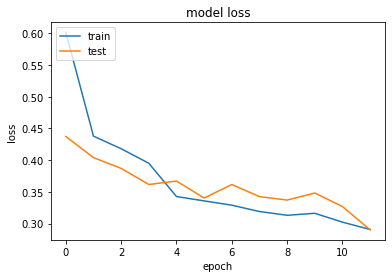

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### 2.FCN

In [54]:
#model = UNET_VGG()
model_nn = FCN2(image_size)
model_nn,history = train(model_nn, dataset, epochs=50, batch_size=40,
                            learning_rate = 1e-4, initialize_weights_vgg=False)
    
model_nn = load_model('models/fcn2_128.h5') 



Epoch 1/50
23/23 [==============================] - 101s 4s/step - loss: 0.6384 - val_loss: 0.5501

Epoch 00001: val_loss improved from inf to 0.55009, saving model to weights.best.hdf5
Epoch 2/50
23/23 [==============================] - 106s 5s/step - loss: 0.4688 - val_loss: 0.4160

Epoch 00002: val_loss improved from 0.55009 to 0.41598, saving model to weights.best.hdf5
Epoch 3/50
23/23 [==============================] - 108s 5s/step - loss: 0.4161 - val_loss: 0.4040

Epoch 00003: val_loss improved from 0.41598 to 0.40396, saving model to weights.best.hdf5
Epoch 4/50
23/23 [==============================] - 108s 5s/step - loss: 0.3991 - val_loss: 0.3964

Epoch 00004: val_loss improved from 0.40396 to 0.39637, saving model to weights.best.hdf5
Epoch 5/50
23/23 [==============================] - 106s 5s/step - loss: 0.3769 - val_loss: 0.3817

Epoch 00005: val_loss improved from 0.39637 to 0.38174, saving model to weights.best.hdf5
Epoch 6/50
23/23 [==============================] - 10


Epoch 00049: val_loss did not improve from 0.33180
Epoch 50/50
23/23 [==============================] - 104s 5s/step - loss: 0.2815 - val_loss: 0.3332

Epoch 00050: val_loss did not improve from 0.33180
Saving model...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


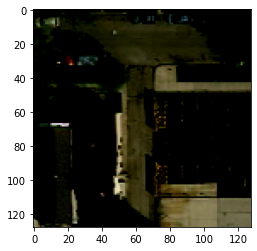

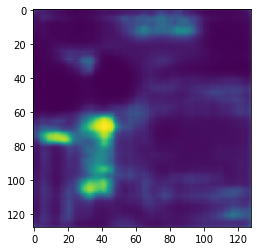

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


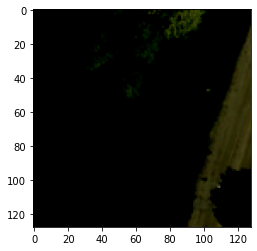

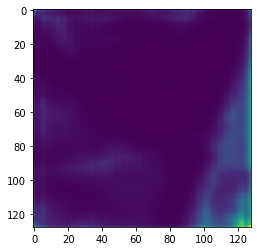

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


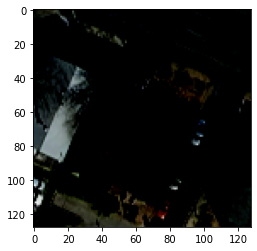

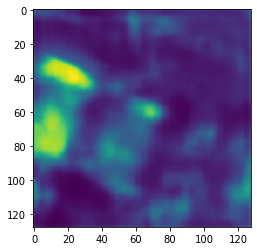

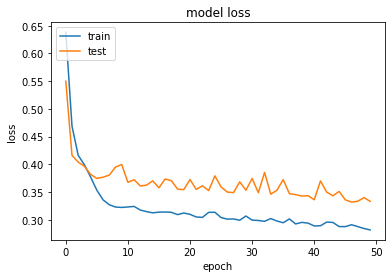

In [58]:
with open('dataset1.pickle', 'rb') as f:
            dataset = pickle.load(f)
            (X_train, Y_train, X_test, Y_test) = dataset
path, dirs, imgs = next(os.walk("AerialImageDataset/train/images1"))
img =load_img("AerialImageDataset/train/images1/" + imgs[0])
plt.imshow(X_train[5].reshape(image_size,image_size,3))
plt.show()
test = model_nn.predict(X_train[5].reshape(1,image_size,image_size,3))
    

#np.save('history/loss_'+model_nn.name+'_'+str(image_size),
            #history.history['loss'])
#np.save('history/val_loss_'+model_nn.name+'_'+str(image_size),
            #history.history['val_loss'])
#plt.imshow(img)
#plt.show()   

plt.imshow(test.reshape((image_size,image_size)))
plt.show()

plt.imshow(X_train[9].reshape(image_size,image_size,3))
plt.show()
test = model_nn.predict(X_train[9].reshape(1,image_size,image_size,3))
plt.imshow(test.reshape((image_size,image_size)))
plt.show()

plt.imshow(X_train[3].reshape(image_size,image_size,3))
plt.show()
test = model_nn.predict(X_train[3].reshape(1,image_size,image_size,3))
plt.imshow(test.reshape((image_size,image_size)))
plt.show()

    
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model loaded
Tiling images...


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Predicting tiles..


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.13it/s]


Image binaryzed


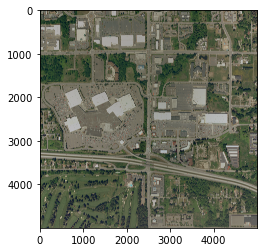

<ipython-input-72-85a4e62ff385>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


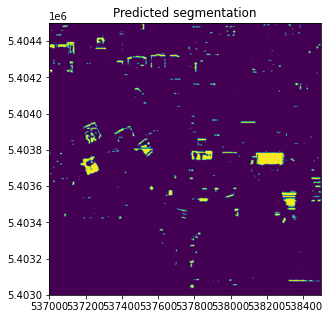

In [72]:
file = 'bellingham23.tif'
test = load_img("AerialImageDataset/train/images/" + file)
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
plt.imshow(test)
plt.show()
fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
plt.title('Predicted segmentation')
ax = fig.add_subplot(111)
ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
plt.show()

Model loaded
Tiling images...


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Predicting tiles..


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.17it/s]


Image binaryzed


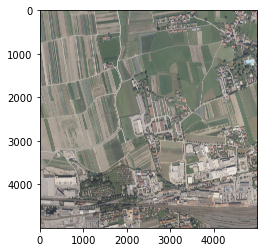

<ipython-input-73-41679572f8fa>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


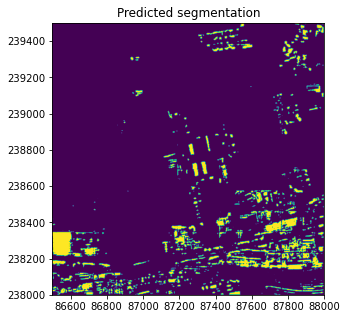

In [73]:
file = 'innsbruck12.tif'
test = load_img("AerialImageDataset/train/images/" + file)
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
plt.imshow(test)
plt.show()
fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
plt.title('Predicted segmentation')
ax = fig.add_subplot(111)
ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
plt.show()

Model loaded
Tiling images...


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Predicting tiles..


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.23it/s]


Image binaryzed


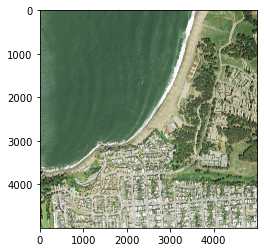

<ipython-input-17-1b437a01c0ee>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


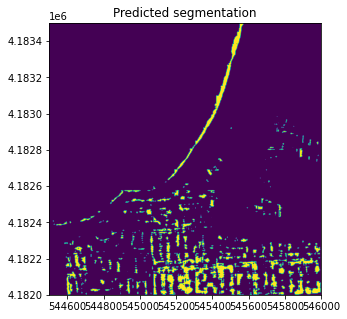

In [17]:
file = 'sfo6.tif'
test = load_img("AerialImageDataset/train/images/" + file)
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
plt.imshow(test)
plt.show()
fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
plt.title('Predicted segmentation')
ax = fig.add_subplot(111)
ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Model loaded
Tiling images...
Predicting tiles..


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.52it/s]

Image binaryzed


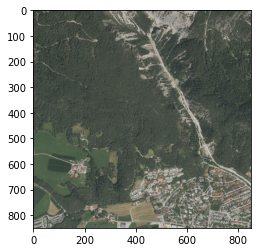

<ipython-input-25-a450cb46d116>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


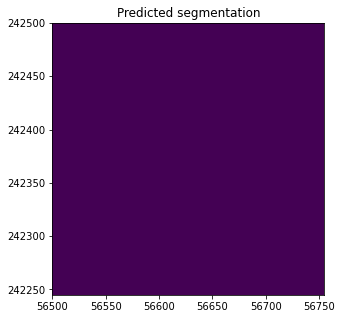

In [25]:
file = 'tirol_gf.tif'
test = load_img("AerialImageDataset/train/images/" + file)
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
plt.imshow(test)
plt.show()
fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
plt.title('Predicted segmentation')
ax = fig.add_subplot(111)
ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
plt.show()

Model loaded


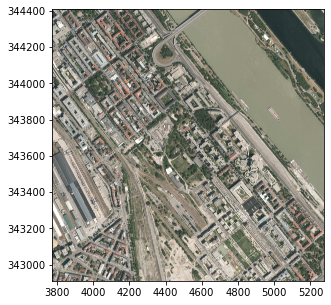

<ipython-input-4-92673c85b3eb>:335: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


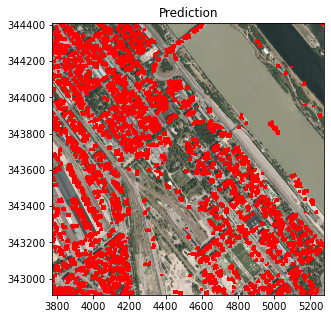

In [59]:
images_train = "AerialImageDataset/train/images/"
gt_train = "AerialImageDataset/train/gt/"    
file = 'vienna5.tif'
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
display_results(file)

Model loaded


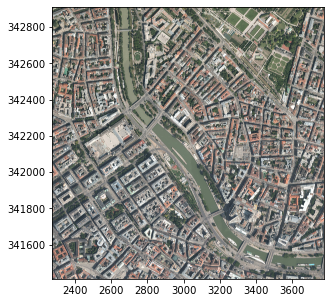

<ipython-input-4-92673c85b3eb>:335: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


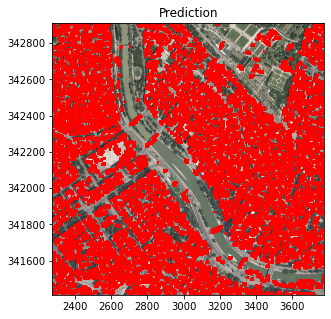

In [60]:
file = 'vienna10.tif'
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
display_results(file)

In [65]:
images_train = "AerialImageDataset/train/images/"
gt_train = "AerialImageDataset/train/gt/"
#compute_iou(images_train,downsampling_factor=4)
#compute_dice(images_train,downsampling_factor=4)
display_stats()

Town
['austin', 'chicago', 'kitsap', 'tyrol-w', 'vienna']
Mean IoU (%)
[38.61429105 39.20152376 16.41453255 44.55950693 49.85239214]
MAX IoU (%)
[47.00947816 48.63491281 41.09770075 56.76228072 63.03386555]
MIN IoU (%)
[29.24569891 20.52415045  1.70593014 28.30513165 26.27066834]
Dice (%)
[55.5622763  56.12284073 26.08099289 61.23952054 65.91518433]


Model loaded
Tiling images...


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Predicting tiles..


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.25it/s]


Image binaryzed


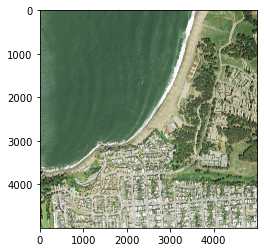

<ipython-input-7-1b437a01c0ee>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


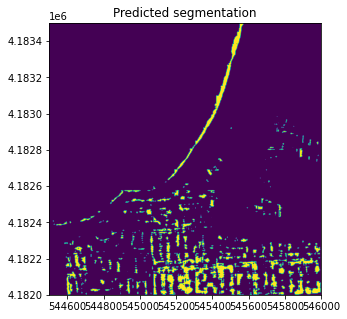

In [7]:
file = 'sfo6.tif'
test = load_img("AerialImageDataset/train/images/" + file)
downsampling_factor=3
tile_size = 128
model_nn = FCN2(tile_size).load_model()
speedups.disable()
predicted_binary, fp = predict_file(file,model_nn,
                                        images_train,
                                        downsampling_factor,tile_size)
plt.imshow(test)
plt.show()
fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
plt.title('Predicted segmentation')
ax = fig.add_subplot(111)
ax.imshow(predicted_binary, extent=[fp.lx, fp.rx, fp.by, fp.ty])
plt.show()

In [24]:
im = Image.open('AerialImageDataset/train/images/tirol.jpg')
im.save("AerialImageDataset/train/images/tirol.tif", 'TIFF')